In [1]:
%matplotlib inline
import seaborn
import numpy as np, scipy as sp, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
from sklearn.decomposition import NMF
plt.rcParams['figure.figsize'] = (20, 10)

In [139]:
x, sr = librosa.load('media/mixture.wav', sr=None)
bf, sr = librosa.load('media/beamformed_dft.wav', sr=None)
print(sr)

8000


In [140]:
ipd.Audio(bf, rate=sr)

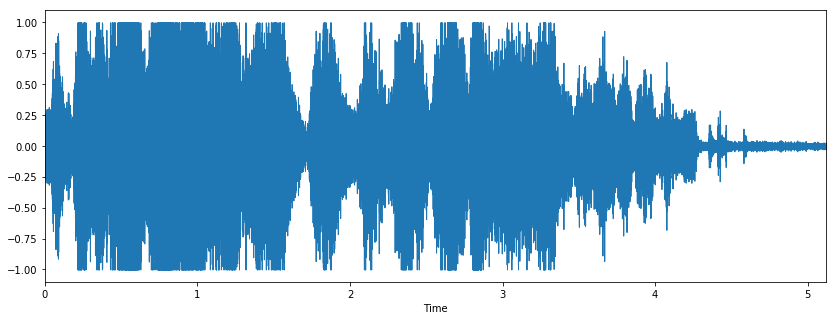

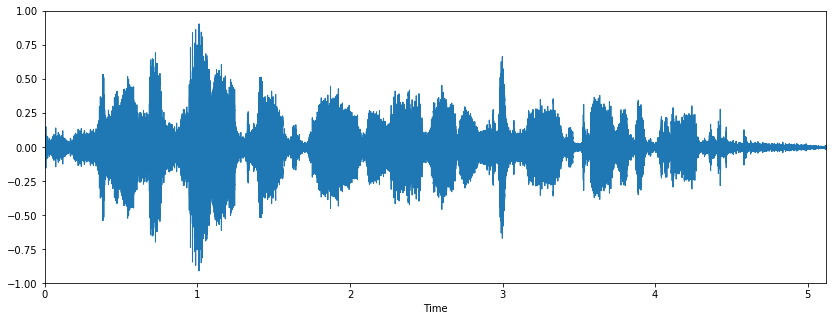

In [141]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(bf, sr=sr)

In [142]:
S = librosa.stft(x, hop_length=32)
print(S.shape)

Sbf = librosa.stft(bf, hop_length=32)
print(Sbf.shape)

(1025, 1281)
(1025, 1281)


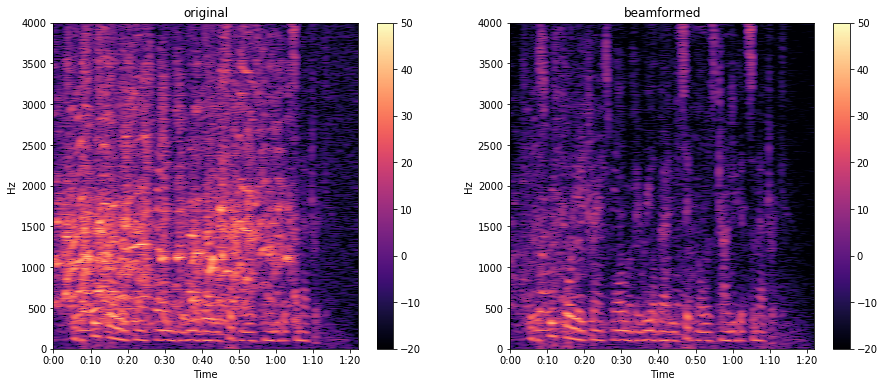

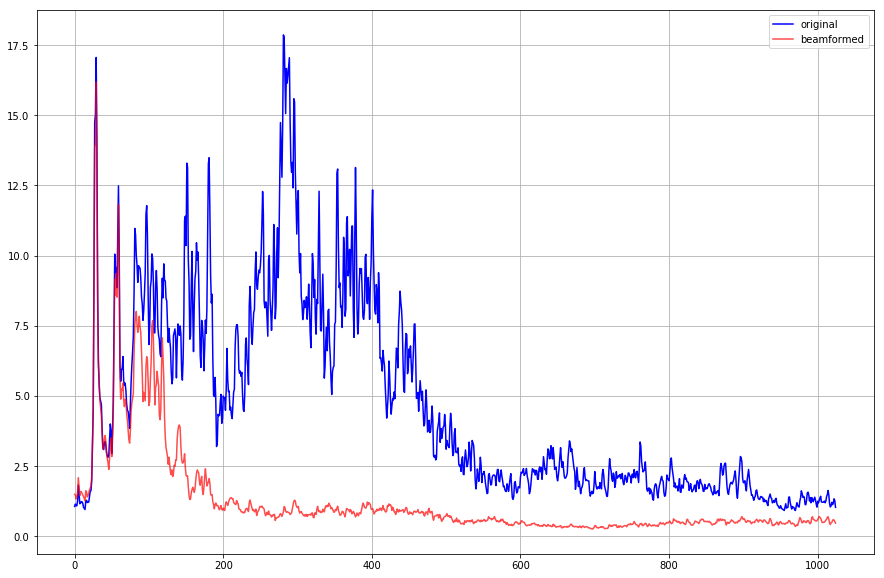

In [145]:
Smag = librosa.magphase(S)[0]
Smagbf = librosa.magphase(Sbf)[0]

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(Smag), sr=sr, x_axis='time', y_axis='linear')
plt.title('original')
plt.colorbar()
plt.set_cmap('magma')
plt.clim(-20, 50);

plt.subplot(1,2,2)
librosa.display.specshow(librosa.amplitude_to_db(Smagbf), sr=sr, x_axis='time', y_axis='linear')
plt.title('beamformed')
plt.colorbar()
plt.set_cmap('magma')
plt.clim(-20, 50);

plt.figure(figsize=(15, 10))
plt.plot(np.average(Smag, 1), 'b')
plt.plot(np.average(Smagbf, 1), 'r', alpha=0.7)
plt.legend(('original', 'beamformed'))
plt.grid(1)


In [146]:
print(np.average(Smag), np.average(Smagbf))

Smag = Smag/np.average(Smag)
Smagbf = Smagbf/np.average(Smagbf)

print(np.max(Smag), np.max(Smagbf))

4.6074753 1.2598071
35.450623 80.92006


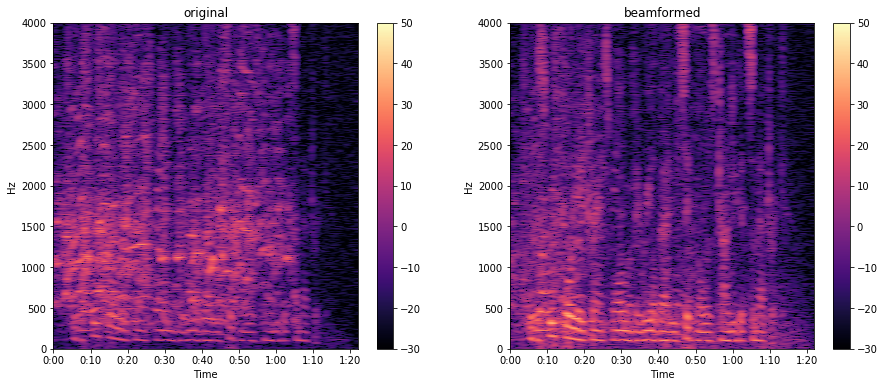

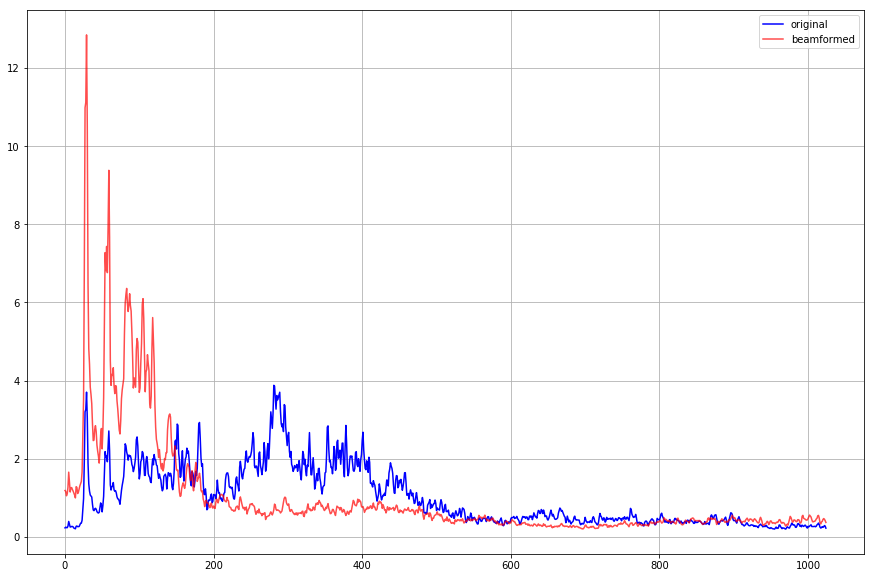

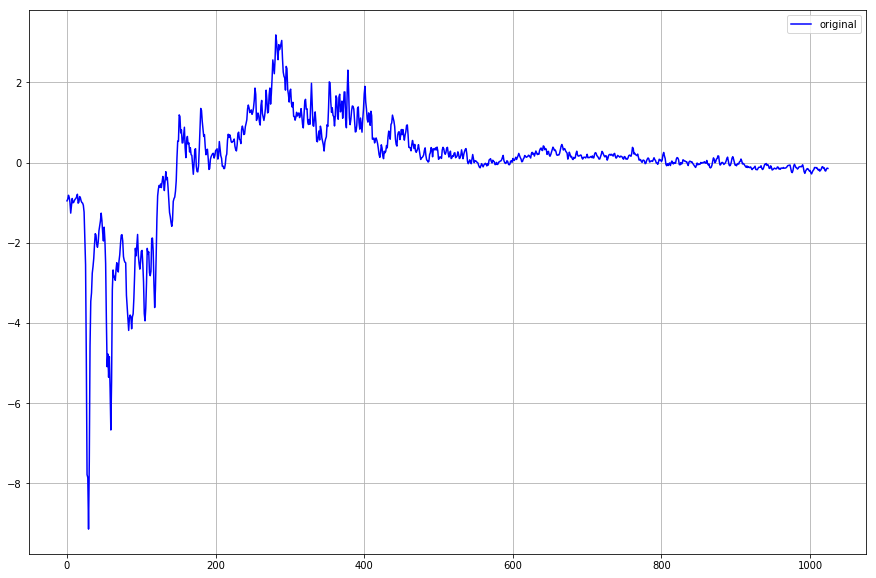

In [150]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(Smag), sr=sr, x_axis='time', y_axis='linear')
plt.title('original')
plt.colorbar()
plt.set_cmap('magma')
plt.clim(-30, 50);

plt.subplot(1,2,2)
librosa.display.specshow(librosa.amplitude_to_db(Smagbf), sr=sr, x_axis='time', y_axis='linear')
plt.title('beamformed')
plt.colorbar()
plt.set_cmap('magma')
plt.clim(-30, 50);

plt.figure(figsize=(15, 10))
plt.plot(np.average(Smag, 1), 'b')
plt.plot(np.average(Smagbf, 1), 'r', alpha=0.7)
plt.legend(('original', 'beamformed'))
plt.grid(1)

#plt.figure(figsize=(15, 10))
#plt.plot(np.average(Smag, 1) - np.average(Smagbf, 1), 'b')
#plt.legend(('original', 'beamformed'))
#plt.grid(1)

In [148]:
X = Smag
n_components = 512
W, H = librosa.decompose.decompose(X, n_components=n_components, sort=True)
print(W.shape)
print(H.shape)

(1025, 512)
(512, 1281)


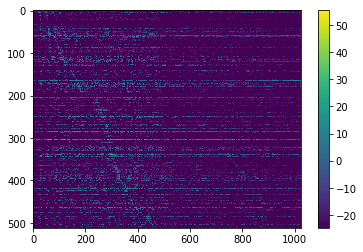

In [149]:
Wmag = librosa.amplitude_to_db(W)
plt.imshow(np.swapaxes(Wmag, 0, 1), aspect='auto', cmap='viridis')
plt.colorbar()

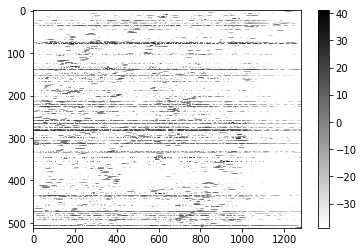

In [151]:
plt.imshow(librosa.amplitude_to_db(H), cmap='gray_r', aspect='auto')
plt.colorbar()

(1025, 1281)


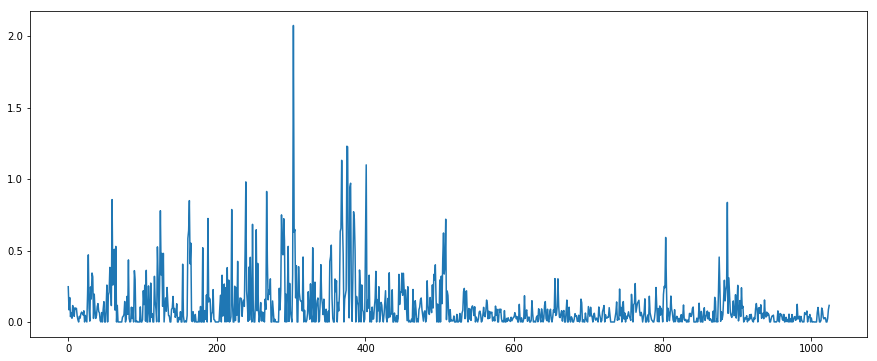

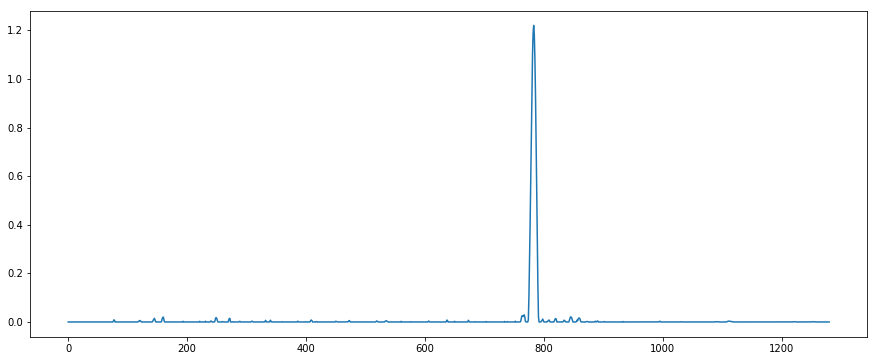

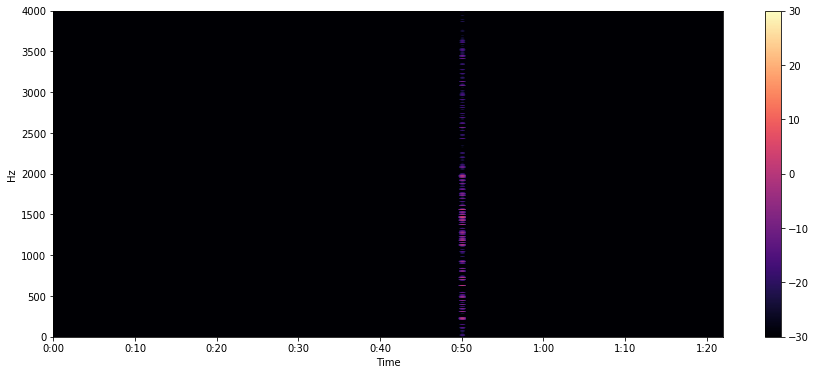

In [180]:
atomSelection = 352

plt.figure(figsize=(15, 6))
plt.plot(W[:,atomSelection])
plt.figure(figsize=(15, 6))
plt.plot(H[atomSelection,:])

atom1mask = W[:,atomSelection].reshape((W[:,1].shape[0], 1))*H[atomSelection,:]
print(atom1mask.shape)

plt.figure(figsize=(15, 6))
librosa.display.specshow(librosa.amplitude_to_db(atom1mask), sr=sr, x_axis='time', y_axis='linear')
plt.colorbar()
plt.clim(-30, 30);

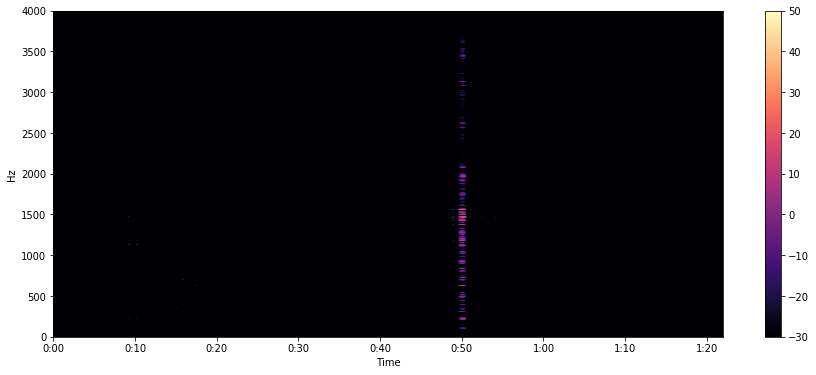

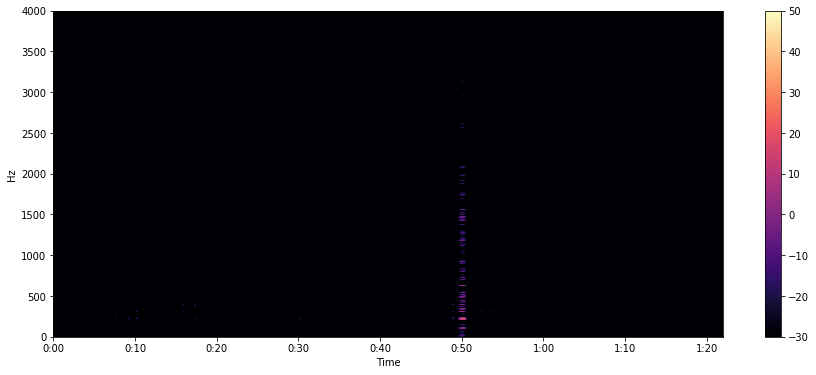

In [181]:
resultmag = np.multiply(Smag, atom1mask)
plt.figure(figsize=(15, 6))
#resultmag = librosa.magphase(result)[0]
librosa.display.specshow(librosa.amplitude_to_db(resultmag), sr=sr, x_axis='time', y_axis='linear')
plt.colorbar()
plt.clim(-30, 50);

resultmagbf = np.multiply(Smagbf, atom1mask)
plt.figure(figsize=(15, 6))
#resultmagbf = librosa.magphase(resultbf)[0]
librosa.display.specshow(librosa.amplitude_to_db(resultmagbf), sr=sr, x_axis='time', y_axis='linear')
plt.colorbar()
plt.clim(-30, 50);

Original :  0.08635290917828865
Beamformed :  0.029838901123423953


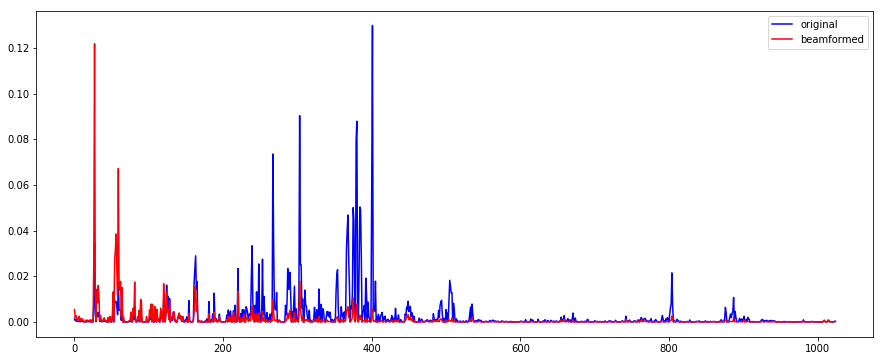

In [182]:
avg = np.average(resultmag, 1)
avgbf = np.average(resultmagbf, 1)

plt.figure(figsize=(15, 6))
plt.plot(avg, 'b')
plt.plot(avgbf, 'r')
plt.legend(('original', 'beamformed'))

instant = np.argmax(H[atomSelection,:])

power = np.sum(avg**2)
power2 = np.sum(librosa.magphase(S[:, instant])[0])
powerbf = np.sum(avgbf**2)
power2bf = np.sum(librosa.magphase(Sbf[:, instant])[0])

print('Original : ', power)
print('Beamformed : ', powerbf)

In [ ]:
#reconstructed_signal = scipy.zeros(len(x))
#for n in range(n_components):
#    Y = scipy.outer(W[:,n], H[n])*numpy.exp(1j*numpy.angle(S))
#    y = librosa.istft(Y)
#    reconstructed_signal[:len(y)] += y

In [ ]:
from matplotlib.collections import LineCollection
from matplotlib.ticker import MultipleLocator

fig = plt.figure("MRI_with_EEG",figsize=(10, 80))
(numSamples, numRows) = H.shape
t = 10.0 * np.arange(numSamples) / numSamples
ticklocs = []
ax2 = fig.add_subplot(2, 2, 1)
ax2.set_xlim(0, 10)
ax2.set_xticks(np.arange(10))
dmin = H.min()
dmax = H.max()
dr = (dmax - dmin) * 0.7  # Crowd them a bit.
y0 = dmin
y1 = (numRows - 1) * dr + dmax
ax2.set_ylim(y0, y1)

segs = []
for i in range(numRows):
    segs.append(np.hstack((t[:, np.newaxis], H[:, i, np.newaxis])))
    ticklocs.append(i * dr)

offsets = np.zeros((numRows, 2), dtype=float)
offsets[:, 1] = ticklocs

lines = LineCollection(segs, offsets=offsets, transOffset=None)
ax2.add_collection(lines)

# Set the yticks to use axes coordinates on the y axis
ax2.set_yticks(ticklocs)

ax2.set_xlabel('Time (s)')


#plt.tight_layout()
plt.show()